In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)
import numpy as np
from numba import jit

/home/agustina/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Code 6.1

In [2]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,brain,mass,species
0,438,37.0,afarensis
1,452,35.5,africanus
2,612,34.5,habilis
3,521,41.5,boisei
4,752,55.5,rudolfensis
5,871,61.0,ergaster
6,1350,53.5,sapiens


#### Code 6.2

In [3]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [4]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

0.4901580479490838

#### Code 6.4

In [5]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [6]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [7]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [8]:
d_new = d.drop(d.index[-1])

#### Code 6.8

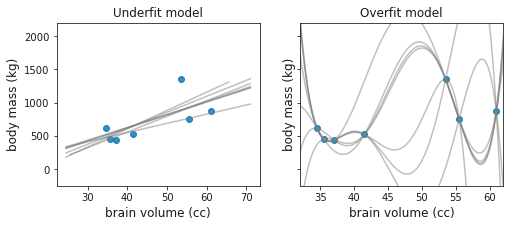

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

In [10]:
p = (0.3, 0.7)
-sum(p*np.log(p))

0.6108643020548935

#### Code 6.10

In [11]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.924989685887567

#### Code 6.11

In [12]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain'])*10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(1000) 

100%|██████████| 1500/1500 [00:03<00:00, 456.73it/s]


In [13]:
theta = pm.df_summary(m_6_8)['mean'][:3]

In [14]:
#compute deviance
dev = -2*sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1]*d['mass_s']  , scale = theta[2]))
dev

100.65085842796987

#### Code 6.12 - 14

The overthinking section corresponding to cells 6.12-14 is not ported because it requires an ad-hoc rethinking package function. Feel free to contribute code to this section.  

#### Code 6.15

In [15]:
data = pd.read_csv('Data/cars.csv', sep=',')

In [16]:
with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(1000) 

100%|██████████| 1500/1500 [00:04<00:00, 305.20it/s]


#### Code 6.16

In [17]:
n_samples = 1000
n_cases = data.shape[0]
ll = np.zeros((n_cases, n_samples))

In [18]:
for s in range(0, n_samples):
    mu = m_6_15['a'][s] + m_6_15['b'][s] * data['speed']
    p_ = stats.norm.logpdf(data['dist'], loc=mu, scale=m_6_15['sigma'][s])
    ll[:,s] = p_

#### Code 6.17

In [19]:
from scipy.misc import logsumexp
n_cases = data.shape[0]
lppd = np.zeros((n_cases))
for a in range(1, n_cases):
    lppd[a,] = logsumexp(ll[a,]) - np.log(n_samples)

#### Code 6.18

In [20]:
pWAIC = np.zeros((n_cases))
for i in range(1, n_cases):
    pWAIC[i,] = np.var(ll[i,])

#### Code 6.19

In [21]:
-2 * (sum(lppd) - sum(pWAIC))

412.09291256678074

#### Code 6.20

In [22]:
waic_vec = -2* (lppd - pWAIC)
np.sqrt(n_cases*np.var(waic_vec))

14.736637905914471

#### Code 6.21

In [23]:
d = pd.read_csv('Data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

(17, 9)

#### Code 6.22

In [24]:
a_start = d['kcal.per.g'].mean()
sigma_start = np.log(d['kcal.per.g'].std())

In [25]:
with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    mu = alpha    
    kcal = pm.Normal('kcal', mu=mu, sd=d['kcal.per.g'].std(), observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(2000)    

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = alpha + beta * d['neocortex']
    kcal = pm.Normal('kcal', mu=mu, sd=d['kcal.per.g'].std(), observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(2000)
    
with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = alpha + beta * np.log(d['mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=d['kcal.per.g'].std(), observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(2000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    mu = alpha + beta[0] * np.log(d['mass']) + beta[1] * d['neocortex']
    kcal = pm.Normal('kcal', mu=mu, sd=d['kcal.per.g'].std(), observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(2000)

100%|██████████| 2500/2500 [00:25<00:00, 97.15it/s]


#### Code 6.23

In [26]:
pm.waic(trace_m6_14, m6_14)

WAIC_r(WAIC=-16.544049195861561, WAIC_se=2.7269064203727038, p_WAIC=1.3783849965770563)

#### Code 6.24

In [27]:
compare_df = pm.compare([trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14], [m6_11, m6_12, m6_13, m6_14], method='pseudo-BMA')
compare_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
3,-16.544,1.37838,0,0.885176,2.72691,0,0
2,-10.9232,1.41786,5.62084,0.0532696,3.94546,2.79358,0
0,-10.4526,0.946702,6.09141,0.0421015,3.75534,3.63696,0
1,-8.90853,1.7193,7.63552,0.0194534,3.43862,3.57171,0


#### Code 6.25

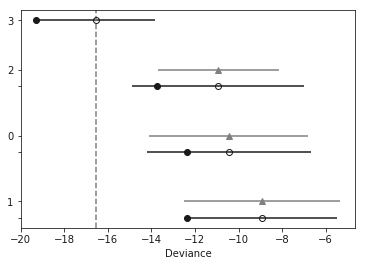

In [28]:
pm.compareplot(compare_df);

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

In [29]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.4
IPython 4.1.2
PyMC3 3.1
NumPy 1.13.1
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.0.2
Seaborn 0.8.0

